In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/czii-cryo-et-object-identification/sample_submission.csv
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/.zattrs
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/.zgroup
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/2/.zarray
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/2/0/0/0
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/0/.zarray
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/0/0/2/2
/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr/0/0/2/0
/kaggle/input/czii-cryo-et-object-identification/test/sta

# Exploratory Data Analysis
The dataset for this competition consists of 3D tomograms containing biological structures. Our task is to identify and classify these structures within the tomograms. To better understand the dataset and prepare for modeling, the following data analysis steps are performed:

1. **Data Visualization**: Visualize 3D tomograms and overlay annotations to explore the spatial distribution of structures and identify any patterns or anomalies.
2. **Class Distribution Analysis**: Analyze the frequency of each structure type to detect class imbalance and visualize their proportions.
3. **Spatial Distribution Analysis**: Plot the locations of structures in 3D space and generate density maps to study spatial patterns or clustering tendencies.

In [2]:
!pip install napari -q
!pip install napari-ome-zarr -q
# Library imports
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import napari
import json

# Constants
ROOT = os.getcwd()
DATA_DIR = '/kaggle/input/czii-cryo-et-object-identification'
TRAIN_ZARRS = '/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns'


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


## Data Visualization 

The first block of code below will open the 3D tomogram images using Napari. It will open a Napari viewer for each experiment. I also added some point layers with the coordinates of each type of structure. Not much information can be extracted from this visualization but it's always good to see what you are dealing with. 
If you want to visualize the 4 different types of zarr files in the training set then change the **tomogram type** (denoised, isonetcorrected, wbp, ctfdeconvolved).

In [3]:
# Choose the type of tomogram to visualize (e.g., 'denoised')
tomogram_type = 'denoised'

structure_colors = {
    'apo-ferritin': 'red',
    'beta-amylase': 'blue',
    'beta-galactosidase': 'green',
    'ribosome': 'yellow',
    'thyroglobulin': 'magenta',
    'virus-like-particle': 'cyan'
}

experiments = os.listdir(TRAIN_ZARRS)

for exp in experiments:
    print(f'Processing experiment: {exp}')
    
    zarr_path = os.path.join(TRAIN_ZARRS, exp, 'VoxelSpacing10.000', f'{tomogram_type}.zarr')
    
    if not os.path.exists(zarr_path):
        print(f'Zarr file not found for experiment {exp}: {zarr_path}')
        continue
    
    viewer = napari.Viewer(title=f'Experiment: {exp}')
    viewer.open(zarr_path)
    
    try:
        viewer.open(zarr_path, plugin='napari-ome-zarr', layer_type='image')
    except Exception as e:
        print(f'Failed to open Zarr file for experiment {exp}: {e}')
        continue
    
    if 'Tomogram' not in viewer.layers:
        for layer in viewer.layers:
            layer.name = 'Tomogram'
    
    structure_coords = {key: [] for key in structure_colors.keys()}
    
    annotations_dir = os.path.join(DATA_DIR, 'train', 'overlay', 'ExperimentRuns', exp, 'Picks')
    
    if not os.path.exists(annotations_dir):
        print(f'Annotations directory not found for experiment {exp}: {annotations_dir}')
        viewer.close()
        continue
    
    annotation_files = os.listdir(annotations_dir)
    
    for annotation_file in annotation_files:
        structure_name = os.path.splitext(annotation_file)[0]
        annotation_path = os.path.join(annotations_dir, annotation_file)
        
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
            points = annotation_data.get('points', [])
            
            coords = []
            for point in points:
                location = point.get('location', {})
                x = location.get('x')
                y = location.get('y')
                z = location.get('z')
                
                if x is not None and y is not None and z is not None:
                    coords.append([z, y, x])  
                else:
                    print(f'Incomplete location data in {annotation_file}: {point}')
        
        if structure_name in structure_coords:
            structure_coords[structure_name].extend(coords)
        else:
            print(f'Unknown structure type: {structure_name}')
    
    for key in structure_coords:
        structure_coords[key] = np.array(structure_coords[key])
    
    for structure_name, coords in structure_coords.items():
        if coords.size == 0:
            continue  
        viewer.add_points(
            coords,
            ndim = 3,
            name=structure_name,
            text=structure_name,
            size=30,  
            face_color=structure_colors[structure_name],
            symbol='o',
            opacity=1.0,
            blending='opaque'
        )

    # napari.run()
    # We can;t run it here since we need to install the plugin from inside the Napari GUI
    

Processing experiment: TS_86_3


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:01,  1.26s/it]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.81it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_6_6


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.21it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.58it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_6_4


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.17it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.66it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_5_4


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  2.48it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  4.15it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_73_6


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.40it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  4.42it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_99_9


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.07it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  4.01it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

Processing experiment: TS_69_2


/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  3.61it/s]
/opt/conda/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
Opening Files: 1it [00:00,  4.65it/s]
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/napari/layers/utils/style_encoding.py:257: RuntimeWarning: Applying the encoding failed. Using the safe fallback value instead.
  warnings.w

## Class Distribution 
The results of the code block below will show a histogram of the number of structures contained in each experiment as well as the total number in the training dataset. We can see that the dataset is highly imbalanced. The most prominent structures are apo-ferritin, ribosomes and thyroglobulin.The beta-amylase has the least amount of examples in the dataset and is not scored for the competition.

<Figure size 1500x700 with 0 Axes>

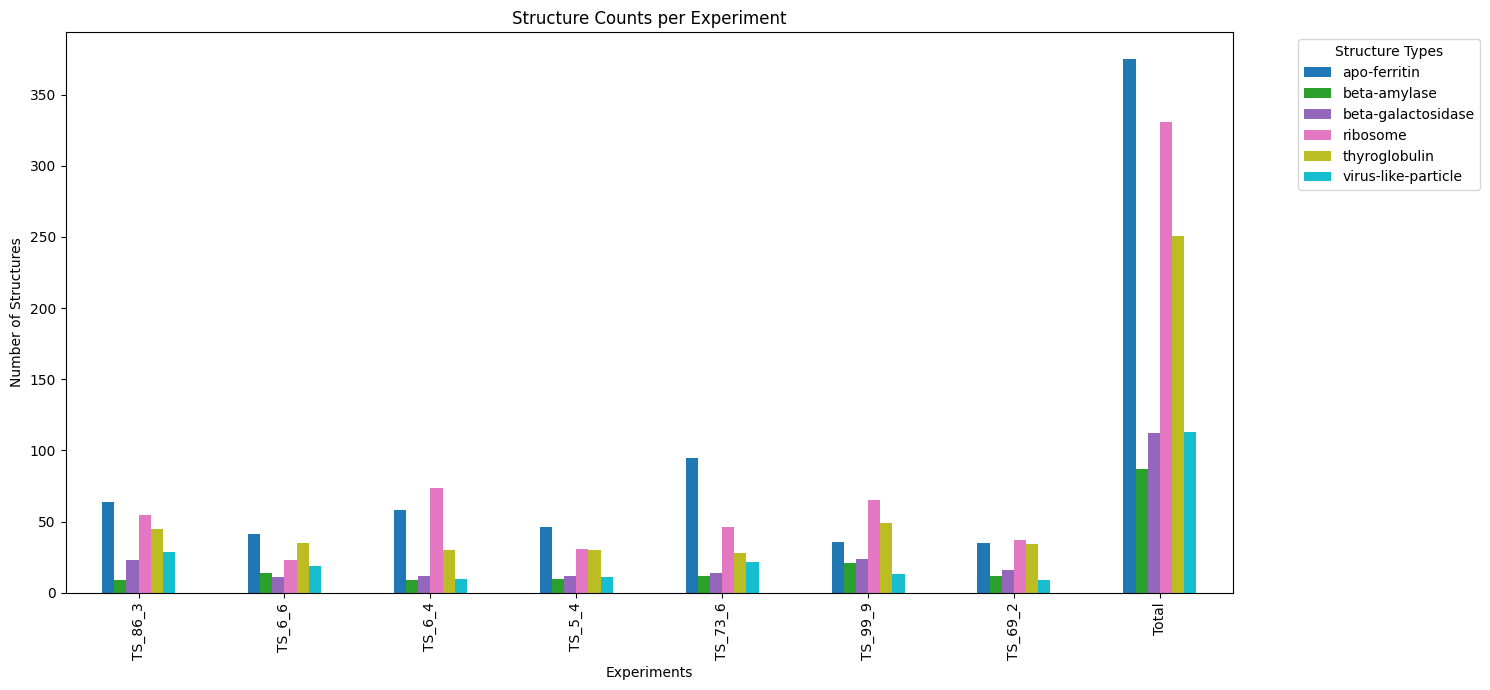

In [4]:
experiments = os.listdir(TRAIN_ZARRS)

# Initialize samples_dict with counts as numbers (not lists)
samples_dict = {exp: {key: 0 for key in structure_colors.keys()} for exp in experiments}

# Iterate over each experiment to populate samples_dict
for exp in experiments:
    annotations_dir = os.path.join(DATA_DIR, 'train', 'overlay', 'ExperimentRuns', exp, 'Picks') 

    annotation_files = os.listdir(annotations_dir)

    for annotation_file in annotation_files:
        structure_name = os.path.splitext(annotation_file)[0]
        annotation_path = os.path.join(annotations_dir, annotation_file)

        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
            num_of_structures = len(annotation_data.get("points", []))

        samples_dict[exp][structure_name] += num_of_structures

structure_counts = pd.DataFrame.from_dict(samples_dict, orient='index')

total_counts = structure_counts.sum().to_frame().T
total_counts.index = ['Total']

structure_counts = pd.concat([structure_counts, total_counts], ignore_index=False)

plt.figure(figsize=(15, 7))
structure_counts.plot(kind='bar', figsize=(15, 7), colormap='tab10')
plt.xlabel('Experiments')
plt.ylabel('Number of Structures')
plt.title('Structure Counts per Experiment')
plt.legend(title='Structure Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Spatial Distribution Analysis
The final block belw calculated the spatial distribution of each structure using the kde plot from seaborn. We can see that most of these structures tend to group together with apo-ferritin being the best example of this phenomenon. Beta-galactosidase has an almost even spread. All structures are most probable to be found in the center of the tomogram.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

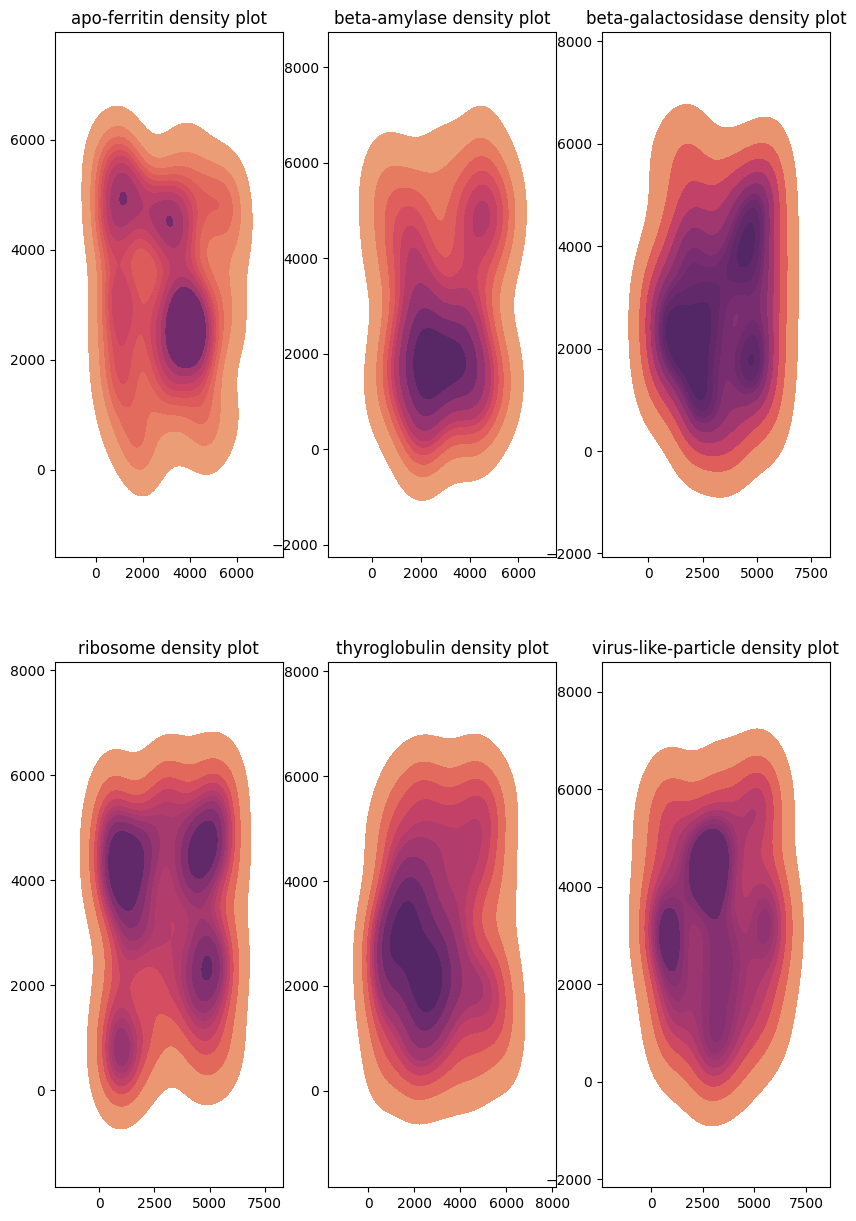

In [5]:
structure_coords = {key: [] for key in structure_colors.keys()}
experiments = os.listdir(TRAIN_ZARRS)

for exp in experiments:    
    zarr_path = os.path.join(TRAIN_ZARRS, exp, 'VoxelSpacing10.000', f'{tomogram_type}.zarr')
    
    if not os.path.exists(zarr_path):
        print(f'Zarr file not found for experiment {exp}: {zarr_path}')
        continue
    
    annotations_dir = os.path.join(DATA_DIR, 'train', 'overlay', 'ExperimentRuns', exp, 'Picks')
    
    annotation_files = os.listdir(annotations_dir)
    
    for annotation_file in annotation_files:
        structure_name = os.path.splitext(annotation_file)[0]
        annotation_path = os.path.join(annotations_dir, annotation_file)
        
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
            points = annotation_data.get('points', [])
            
            coords = []
            for point in points:
                location = point.get('location', {})
                x = location.get('x')
                y = location.get('y')
                z = location.get('z')
                
                if x is not None and y is not None and z is not None:
                    coords.append([x, y, z])  
                else:
                    print(f'Incomplete location data in {annotation_file}: {point}')
        
        if structure_name in structure_coords:
            structure_coords[structure_name].extend(coords)

plt.figure(figsize=(10, 15))

for i, (structure_name, coords) in enumerate(structure_coords.items()):
    coords = np.array(coords)
    x = coords[:, 0]
    y = coords[:, 1]

    plt.subplot(2, 3, i+1)
    plt.title(f"{structure_name} density plot")
    sns.kdeplot(x=x, y=y, cmap='flare', fill=True)

plt.show()